# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [1]:
# Load the libraries as required.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import RobustScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import shap
import pickle

In [2]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [3]:
# Defines features (X) and target (Y)
X = fires_dt.drop('area', axis=1)
Y = fires_dt['area']

In [4]:
# Split the data into train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [5]:
# Identify numerical and categorical columns
numeric_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
categorical_features = ['month', 'day']

# Define preprocessor 1 - Simple scaling and encoding
preproc1 = ColumnTransformer(
    transformers=[
        ('num_transforms', RobustScaler(), numeric_features),
        ('cat_transforms', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
preproc1

ColumnTransformer(transformers=[('num_transforms', RobustScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat_transforms',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [6]:
# Define the subset of numeric features for PowerTransformer
power_transform_features = ['temp', 'dmc',  'rh'] 
remaining_numeric_features = ['coord_x', 'coord_y', 'ffmc', 'dc', 'isi', 'wind', 'rain']


# Define preprocessor with specific transformations
preproc2 = ColumnTransformer(
    transformers=[
        # Apply RobustScaler and PowerTransformer to specified features
        ('num_transforms', Pipeline([
            ('scaler', RobustScaler()),
            ('transform', PowerTransformer())
        ]), power_transform_features),
        
        # Apply only RobustScaler to remaining numeric features
        ('num_scaling', RobustScaler(), remaining_numeric_features),
        
        # Apply OneHotEncoder to categorical features
        ('cat_transforms', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

preproc2

ColumnTransformer(transformers=[('num_transforms',
                                 Pipeline(steps=[('scaler', RobustScaler()),
                                                 ('transform',
                                                  PowerTransformer())]),
                                 ['temp', 'dmc', 'rh']),
                                ('num_scaling', RobustScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dc', 'isi',
                                  'wind', 'rain']),
                                ('cat_transforms',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [7]:
# Define baseline model and parameter grid for tuning (using KNeighborsRegressor)
knn = KNeighborsRegressor()
knn_params = {
    'regressor__n_neighbors': [3, 5, 7, 9],
    'regressor__weights': ['uniform', 'distance']
}

# Define advanced model and parameter grid for tuning (using XGBRegressor)
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_params = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [3, 6, 10],
    'regressor__learning_rate': [0.01, 0.1, 0.2]
}

In [8]:
# Pipeline A = preproc1 + baseline

pipeline_a = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', knn)
])

# Grid Search for Pipeline A
grid_a = GridSearchCV(pipeline_a, param_grid=knn_params, cv=5, scoring='neg_root_mean_squared_error')

In [9]:
# Pipeline B = preproc2 + baseline

pipeline_b = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', knn)
])

# Grid Search for Pipeline B
grid_b = GridSearchCV(pipeline_b, param_grid=knn_params, cv=5, scoring='neg_root_mean_squared_error')


In [10]:
# Pipeline C = preproc1 + advanced model

pipeline_c = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', xgb)
])

# Grid Search for Pipeline C
grid_c = GridSearchCV(pipeline_c, param_grid=xgb_params, cv=5, scoring='neg_root_mean_squared_error')

In [11]:
# Pipeline D = preproc2 + advanced model

pipeline_d = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', xgb)
])

# Grid Search for Pipeline D
grid_d = GridSearchCV(pipeline_d, param_grid=xgb_params, cv=5, scoring='neg_root_mean_squared_error')
    

In [12]:
# Fit and evaluate Pipeline A
grid_a.fit(X_train, Y_train)
print("Pipeline A - Best RMSE Score:", -grid_a.best_score_)
print("Pipeline A - Best Params:", grid_a.best_params_)

# Fit and evaluate Pipeline B
grid_b.fit(X_train, Y_train)
print("Pipeline B - Best RMSE Score:", -grid_b.best_score_)
print("Pipeline B - Best Params:", grid_b.best_params_)

# Fit and evaluate Pipeline C
grid_c.fit(X_train, Y_train)
print("Pipeline C - Best RMSE Score:", -grid_c.best_score_)
print("Pipeline C - Best Params:", grid_c.best_params_)

# Fit and evaluate Pipeline D
grid_d.fit(X_train, Y_train)
print("Pipeline D - Best RMSE Score:", -grid_d.best_score_)
print("Pipeline D - Best Params:", grid_d.best_params_)

Pipeline A - Best RMSE Score: 42.40919656510841
Pipeline A - Best Params: {'regressor__n_neighbors': 9, 'regressor__weights': 'uniform'}
Pipeline B - Best RMSE Score: 42.038651571543994
Pipeline B - Best Params: {'regressor__n_neighbors': 9, 'regressor__weights': 'uniform'}
Pipeline C - Best RMSE Score: 41.357646929160694
Pipeline C - Best Params: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 50}
Pipeline D - Best RMSE Score: 41.23543466452651
Pipeline D - Best Params: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 50}


# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [14]:
# Expanded parameter grid for KNeighborsRegressor in Pipelines A and B
knn = KNeighborsRegressor()
knn_params_extended = {
    'regressor__n_neighbors': [5, 7, 9, 11],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__p': [1, 2]  # 'p' parameter for distance metric, 1: Manhattan, 2: Euclidean
}

# Expanded parameter grid for XGBRegressor in Pipelines C and D
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_params_extended = {
    'regressor__n_estimators': [50, 100, 150],
    'regressor__max_depth': [3, 6, 10],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__subsample': [0.6, 0.8, 1.0]  # subsample ratio for training instances
}

In [15]:
# Update GridSearchCV for each pipeline with expanded parameter grids

# Pipeline A: preproc1 + baseline (knn) with extended params
grid_a = GridSearchCV(
    Pipeline([('preprocessing', preproc1), ('regressor', knn)]),
    param_grid=knn_params_extended,
    cv=5, scoring='neg_root_mean_squared_error'
)

In [16]:
# Pipeline B: preproc2 + baseline (knn) with extended params
grid_b = GridSearchCV(
    Pipeline([('preprocessing', preproc2), ('regressor', knn)]),
    param_grid=knn_params_extended,
    cv=5, scoring='neg_root_mean_squared_error'
)

In [17]:
# Pipeline C: preproc1 + advanced model (xgb) with extended params
grid_c = GridSearchCV(
    Pipeline([('preprocessing', preproc1), ('regressor', xgb)]),
    param_grid=xgb_params_extended,
    cv=5, scoring='neg_root_mean_squared_error'
)

In [18]:
# Pipeline D: preproc2 + advanced model (xgb) with extended params
grid_d = GridSearchCV(
    Pipeline([('preprocessing', preproc2), ('regressor', xgb)]),
    param_grid=xgb_params_extended,
    cv=5, scoring='neg_root_mean_squared_error'
)

In [19]:
# Fit each grid and report the best score and parameters
for name, grid in zip(['Pipeline A', 'Pipeline B', 'Pipeline C', 'Pipeline D'], [grid_a, grid_b, grid_c, grid_d]):
    grid.fit(X_train, Y_train)
    print(f"{name} - Best RMSE Score: {-grid.best_score_}")
    print(f"{name} - Best Params: {grid.best_params_}")

Pipeline A - Best RMSE Score: 41.48619398383979
Pipeline A - Best Params: {'regressor__n_neighbors': 11, 'regressor__p': 2, 'regressor__weights': 'uniform'}
Pipeline B - Best RMSE Score: 40.63802410652089
Pipeline B - Best Params: {'regressor__n_neighbors': 11, 'regressor__p': 2, 'regressor__weights': 'uniform'}
Pipeline C - Best RMSE Score: 39.133160962570976
Pipeline C - Best Params: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 50, 'regressor__subsample': 0.6}
Pipeline D - Best RMSE Score: 39.20167847231333
Pipeline D - Best Params: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 50, 'regressor__subsample': 0.6}


# Evaluate

+ Which model has the best performance?

__My answer:__
<br> Since a lower RMSE indicates better performance, Pipeline C (using preproc1 with XGBRegressor model) demonstrated the best predictive accuracy with the lowest RMSE score of approx. 39.13. Therefore, Pipeline C has the best performance. 

# Export

+ Save the best performing model to a pickle file.

In [20]:
# Pipeline C is chosen as the best model with the tuned parameters
best_model = grid_c.best_estimator_

In [21]:
# Save the model to a pickle file
with open("best_model_pipe_c.pkl", "wb") as file:
    pickle.dump(best_model, file)

print("Best performing model saved as best_model_pipe_c.pkl")

Best performing model saved as best_model_pipe_c.pkl


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [22]:
# Load the best model
with open("best_model_pipe_c.pkl", "rb") as file:
    pipe = pickle.load(file)

# Fit the best model pipeline on training data
pipe.fit(X_train, Y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  RobustScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_transforms',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=50, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

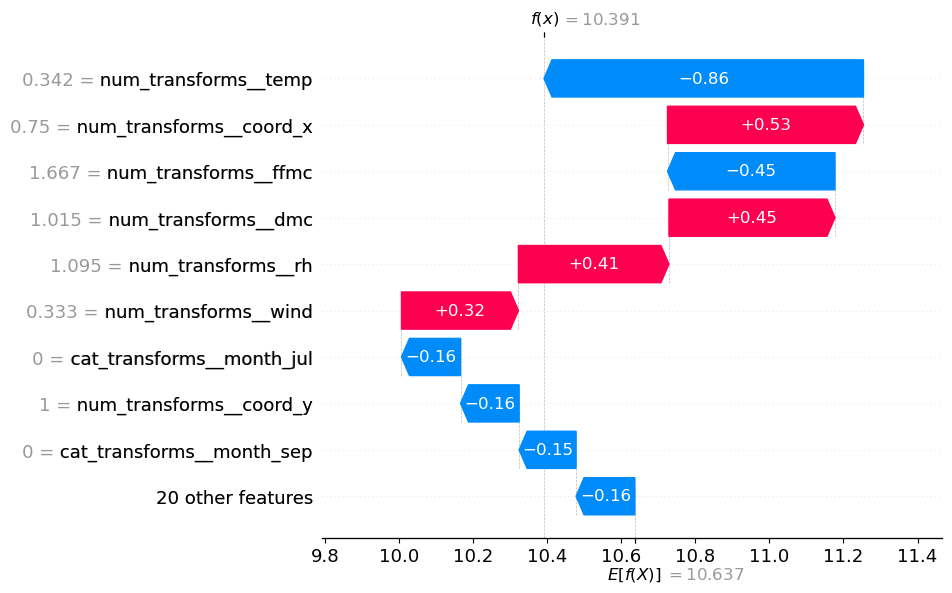

In [23]:
# Extract the preprocessing and model steps
preprocessor = pipe.named_steps['preprocessing']
model = pipe.named_steps['regressor']

# Apply the preprocessing step to X_test
X_test_preprocessed = preprocessor.transform(X_test)

# Use TreeExplainer for the XGBRegressor model
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_preprocessed)

# Plot a SHAP local waterfall plot for a single prediction, e.g., the second prediction
shap.plots.waterfall(shap.Explanation(values=shap_values[1], 
                                      base_values=explainer.expected_value,
                                      data=X_test_preprocessed[1],
                                      feature_names=preprocessor.get_feature_names_out()))


__Local explanation:__
<br> Above local waterfall plot of the second observation in the test set indicates that temp is the locally most important feature. coord_x, ffmc, dmc and rh are the second, third, fourth and fifth most important feature, respectively. These SHAP values are valid for this observation only. With other data points the SHAP values will change. 

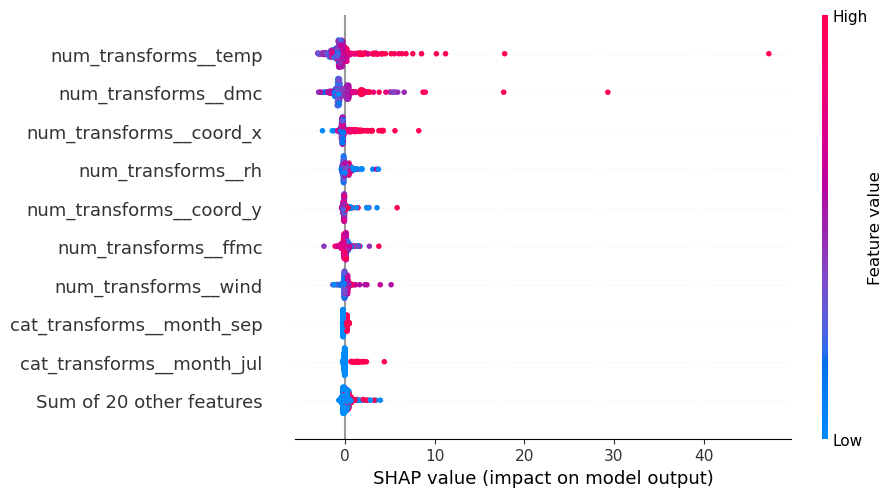

In [24]:
# Apply the preprocessing step to X_train
X_train_preprocessed = preprocessor.transform(X_train)

# Get the feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Use TreeExplainer for the XGBRegressor model
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train_preprocessed)  # This now returns an Explanation object

# Update shap_values with feature names for clearer labeling
shap_values.feature_names = feature_names

# Create a SHAP global beeswarm plot
shap.plots.beeswarm(shap_values)

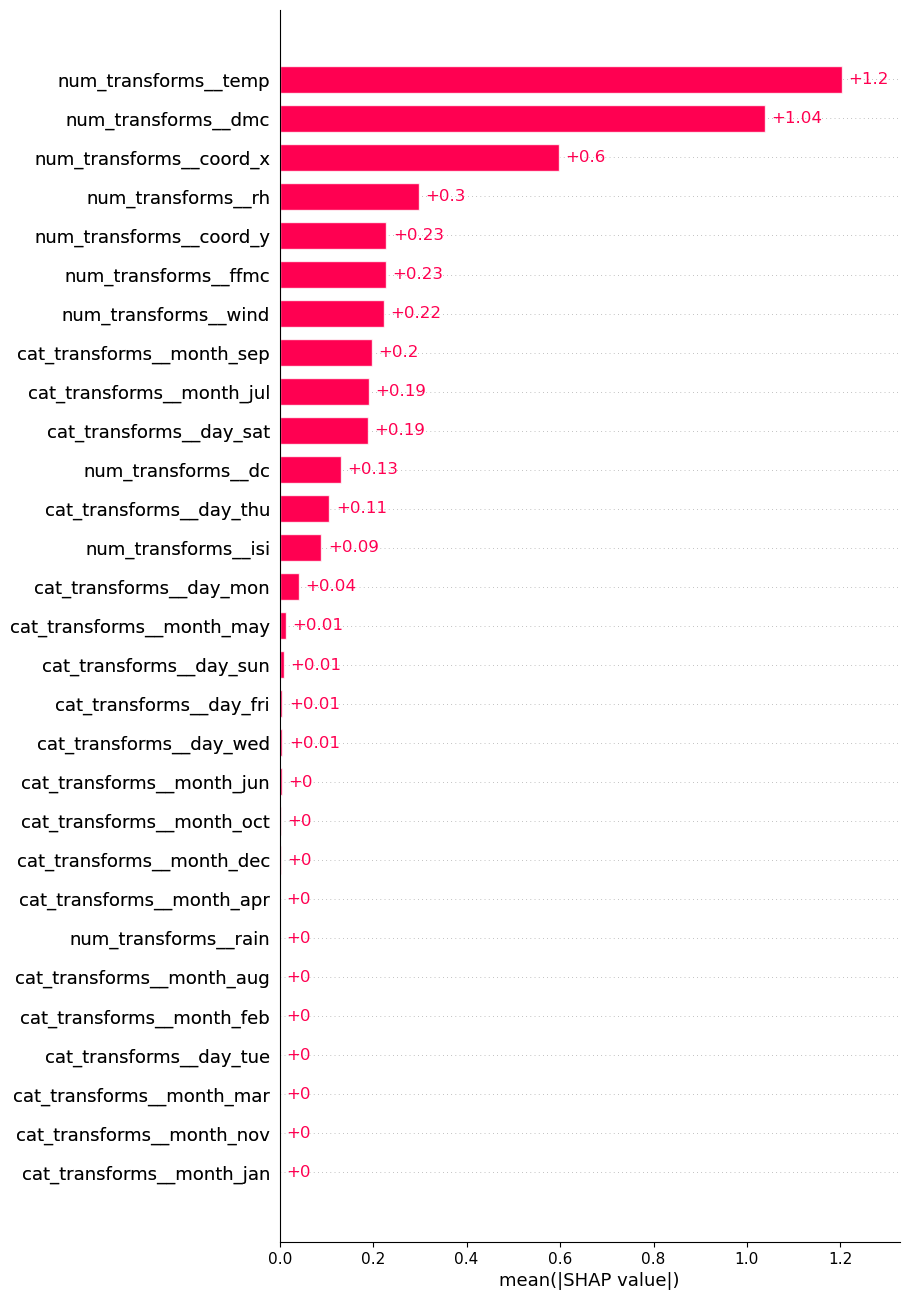

In [25]:
# Create a SHAP global bar plot
shap.plots.bar(shap_values, max_display=29)

__Global explanation:__
<br> Above global bee swarm plot and bar plot indicate that temp is the globally most important feature across the complete training set. The temp variable generally has a fairly high positive contribution on the prediction when its values are high. Globally, dmc is the second most important feature; coord_x is the third most important feature. Globally, rain is the least important feature. 

*(Answer here.)*
<br> If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?
<br> __My answer:__
<br> 1. __Identifying Low-Importance Features to Remove:__ If I were to remove features from the model, I would start with those with zero or near-zero SHAP values. Based on my SHAP analysis, I would first remove rain from the model, as features with zero or near-zero SHAP values contribute minimally to model predictions and could be considered for removal. 
<br> 2. __Test Impact of Removing Features:__ Remove each low-importance feature and retrain the model, comparing performance with metrics like RMSE or MAE. If metrics remain stable, the feature likely doesn’t enhance performance.
<br> 3.__Confirm with Cross-Validation:__ Run cross-validation after feature removal to ensure generalization. If removing a feature doesn’t worsen performance, it can be confidently excluded.
<br> Hence, SHAP helped us streamline the model by revealing features that added minimal predictive value.

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.